In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import pickle
from collections import Counter
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [ ]:
def read_data(file_path):
    with open(file_path, 'rb') as f:
        data_pkl = pickle.load(f)
        return data_pkl

rna_pickle_file_name = "/content/drive/MyDrive/Colab Notebooks/data/liver_rna_seq_data.pkl"
data_rna_meta = read_data(rna_pickle_file_name)
data_rna_meta = data_rna_meta.fillna(0)
data_rna_meta = data_rna_meta[data_rna_meta['Sample ID'] != "A_10_19"]
print("rna sequencing data shape : %s" % str(data_rna_meta.shape))

liver_meta_pickle_file_name = "/content/drive/MyDrive/Colab Notebooks/data/diet/liver_metabolimics_all.pkl"
data_liver_meta = read_data(liver_meta_pickle_file_name)
data_liver_meta = data_liver_meta.fillna(0)
data_liver_meta.loc[(data_liver_meta['Genotype'].str.find('WT') != -1),'Genotype']='WT'
data_liver_meta.loc[(data_liver_meta['Genotype'].str.find('FXR') != -1),'Genotype']='FXRKO'
print("liver metabolomics shape : %s" % str(data_liver_meta.shape))

serum_meta_pickle_file_name = "/content/drive/MyDrive/Colab Notebooks/data/diet/metabolomics_serum.pkl"
data_serum_meta = read_data(serum_meta_pickle_file_name)
data_serum_meta = data_serum_meta.fillna(0)
data_serum_meta.loc[(data_serum_meta['Genotype'].str.find('WT') != -1),'Genotype']='WT'
data_serum_meta.loc[(data_serum_meta['Genotype'].str.find('FXR') != -1),'Genotype']='FXRKO'
print("serum metabolomics shape : %s" % str(data_serum_meta.shape))

urine_meta_pickle_file_name = "/content/drive/MyDrive/Colab Notebooks/data/diet/metabolomics_urine.pkl"
data_urine_meta = read_data(urine_meta_pickle_file_name)
data_urine_meta = data_urine_meta.fillna(0)
data_urine_meta.loc[(data_urine_meta['Genotype'].str.find('WT') != -1),'Genotype']='WT'
data_urine_meta.loc[(data_urine_meta['Genotype'].str.find('FXR') != -1),'Genotype']='FXRKO'
print("urine metabolomics shape : %s" % str(data_urine_meta.shape))

cecal_micro_pickle_file_name = "/content/drive/MyDrive/Colab Notebooks/data/cecal_microbiota_data.pkl"
data_cecal_micro = read_data(cecal_micro_pickle_file_name)
data_cecal_micro = data_cecal_micro.fillna(0)
data_cecal_micro.loc[(data_cecal_micro['Genotype'].str.find('WT') != -1),'Genotype']='WT'
data_cecal_micro.loc[(data_cecal_micro['Genotype'].str.find('FXR') != -1),'Genotype']='FXRKO'
print("cecal micro shape : %s" % str(data_cecal_micro.shape))

bile_acid_pickle_file_name = "/content/drive/MyDrive/Colab Notebooks/data/bile/bile_acid.pkl"
data_bile_acid = read_data(bile_acid_pickle_file_name)
data_bile_acid = data_bile_acid.fillna(0)
data_bile_acid = data_bile_acid.replace("No Peak",0)
print("bile acid shape : %s" % str(data_bile_acid.shape))

rna sequencing data shape : (47, 54313)
liver metabolomics shape : (72, 584)
serum metabolomics shape : (186, 59)
urine metabolomics shape : (247, 60)
cecal micro shape : (238, 379)
bile acid shape : (186, 16)


In [ ]:
def get_feature_list(file_path_name,sheet_name="Combined",column_value=0):
  features = pd.read_excel(file_path_name, sheet_name)
  features_list = features.iloc[:,column_value].tolist()
  return features_list

rna_combined_file = "/content/drive/MyDrive/Colab Notebooks/data/fxr_ko/105_FXR KO vs WT_RNA seq.xlsx"
rna_combined_features_list = get_feature_list(rna_combined_file,"Sheet1")
# because there are two columns in original rna data whose name is‘Gm13301' ，so we remove this feature from the combined feature list.
rna_combined_features_list.remove("Gm13301")
print("the size of selected features list from rna sequencing: %s" % str(len(rna_combined_features_list)))

rna_combined_file_no_pseudo = "/content/drive/MyDrive/Colab Notebooks/data/fxr_ko/No pseudo_105_FXR KO vs WT_RNA seq.xlsx"
rna_combined_features_list_no_pseudo = get_feature_list(rna_combined_file_no_pseudo,"Sheet2")
print("the size of selected features list from rna sequencing without pseudogene: %s" % str(len(rna_combined_features_list_no_pseudo)))


liver_combined_file = "/content/drive/MyDrive/Colab Notebooks/data/fxr_ko/101_Liver metabolites_FXR KO vs WT_Uni.xlsx"
liver_combined_features_list = get_feature_list(liver_combined_file)
print("the size of selected features list from liver metabolites: %s" % str(len(liver_combined_features_list)))

serum_combined_file = "/content/drive/MyDrive/Colab Notebooks/data/fxr_ko/42_Serum metabolites_FXR KO vs WT_Uni.xlsx"
serum_combined_features_list = get_feature_list(serum_combined_file)
print("the size of selected features list from serum metabolites: %s" % str(len(serum_combined_features_list)))

urine_combined_file = "/content/drive/MyDrive/Colab Notebooks/data/fxr_ko/51_Urine metabolites_FXR KO vs WT_Uni.xlsx"
urine_combined_features_list = get_feature_list(urine_combined_file)
print("the size of selected features list from urine metabolites: %s" % str(len(urine_combined_features_list)))

cecal_combined_file = "/content/drive/MyDrive/Colab Notebooks/data/fxr_ko/33_Cecal microbiota_FXR KO vs WT_Uni.xlsx"
cecal_combined_features_list = get_feature_list(cecal_combined_file,"Sheet1",2)
print("the size of selected features list from cecal micro: %s" % str(len(cecal_combined_features_list)))

the size of selected features list from rna sequencing: 104
the size of selected features list from rna sequencing without pseudogene: 68
the size of selected features list from liver metabolites: 101
the size of selected features list from serum metabolites: 42
the size of selected features list from urine metabolites: 51
the size of selected features list from cecal micro: 33


In [ ]:
bile_acid_combined_features_list =  data_bile_acid.columns.to_list()[4:]

In [ ]:
def get_data_x_y(data_ori,feature_list):

  genotype_str = "Genotype"
  data_ori_x = data_ori[(data_ori[genotype_str] == "WT") | (data_ori[genotype_str] == "FXRKO")][feature_list].reset_index(drop=True)
  data_ori_y = data_ori[(data_ori[genotype_str] == "WT") | (data_ori[genotype_str] == "FXRKO")][genotype_str].reset_index(drop=True)
  return data_ori_x,data_ori_y

X_rna,y_rna = get_data_x_y(data_rna_meta,rna_combined_features_list)
X_rna_no_pseudo,y_rna_no_pseudo = get_data_x_y(data_rna_meta,rna_combined_features_list_no_pseudo)
X_liver,y_liver = get_data_x_y(data_liver_meta,liver_combined_features_list)
X_serum,y_serum = get_data_x_y(data_serum_meta,serum_combined_features_list)
X_urine,y_urine = get_data_x_y(data_urine_meta,urine_combined_features_list)
X_cecal,y_cecal = get_data_x_y(data_cecal_micro,cecal_combined_features_list)

In [ ]:
def get_data_x_y(data_ori,feature_list,sex_str):
  data_ori = data_ori[data_ori['Sex'] == sex_str]

  genotype_str = "Genotype"
  data_ori_x = data_ori[(data_ori[genotype_str] == "WT") | (data_ori[genotype_str] == "FXRKO")][feature_list].reset_index(drop=True)
  data_ori_y = data_ori[(data_ori[genotype_str] == "WT") | (data_ori[genotype_str] == "FXRKO")][genotype_str].reset_index(drop=True)
  return data_ori_x,data_ori_y


X_serum_male,y_serum_male = get_data_x_y(data_serum_meta,serum_combined_features_list,"M")
X_urine_male,y_urine_male = get_data_x_y(data_urine_meta,urine_combined_features_list,"M")
X_cecal_male,y_cecal_male = get_data_x_y(data_cecal_micro,cecal_combined_features_list,"Male")

In [ ]:
def get_data_x_y(data_ori,feature_list):

  genotype_str = "Genotype"
  data_ori_x = data_ori[(data_ori[genotype_str] == "WT") | (data_ori[genotype_str] == "FXRKO")][feature_list].reset_index(drop=True)
  data_ori_y = data_ori[(data_ori[genotype_str] == "WT") | (data_ori[genotype_str] == "FXRKO")][genotype_str].reset_index(drop=True)
  return data_ori_x,data_ori_y

X_bile,y_bile = get_data_x_y(data_bile_acid,bile_acid_combined_features_list)

In [ ]:
def all_features_importance(clf,data_x,data_y,abs_flag):

  scaler = StandardScaler()
  scaler.fit(data_x)
  data_x_scaler = scaler.transform(data_x)

  clf.fit(data_x_scaler,data_y)
  imp = abs(clf.coef_[0]) if abs_flag else clf.coef_[0]
  all_features_list = data_x.columns.tolist()
  print(all_features_list)
  imp, names = zip(*sorted(list(zip(imp, all_features_list))))
  columns_name = list(names)
  columns_name.reverse()
  print(imp)
  print("columns_name : %s" % str(columns_name))
  print("columns_name shape: %s" % str(len(columns_name)))
  return columns_name
clf=SVC(kernel='linear')
rna_linear_features_important = all_features_importance(clf,X_rna,y_rna,True)
rna_linear_features_important_no_pseudo = all_features_importance(clf,X_rna_no_pseudo,y_rna_no_pseudo,True)
liver_linear_features_important = all_features_importance(clf,X_liver,y_liver,True)
serum_linear_features_important = all_features_importance(clf,X_serum,y_serum,True)
urine_linear_features_important = all_features_importance(clf,X_urine,y_urine,True)
cecal_linear_features_important = all_features_importance(clf,X_cecal,y_cecal,True)
serum_male_linear_features_important = all_features_importance(clf,X_serum_male,y_serum_male,True)
urine_male_linear_features_important = all_features_importance(clf,X_urine_male,y_urine_male,True)
cecal_male_linear_features_important = all_features_importance(clf,X_cecal_male,y_cecal_male,True)

['Gm15459', 'Gm9008', 'Gm7879', 'Ndufa12-ps', 'Ndufs5-ps', 'Rps7-ps3', 'Rpl35a-ps2', 'Abhd1', 'Gm12191', 'Psmc3ip', 'Gm10184', 'Cyp4a30-ps', 'Gm12248', 'Gm20075', 'Mup-ps10', 'Sema3e', 'Mup-ps4', 'Gm50216', 'Gm47738', 'Ubb-ps', 'Gm8797', 'Gm12663', 'Rhbg', 'Cyp2a5', 'Pcna-ps2', 'Rian', 'Meg3', 'Gm8615', 'Gstm2', 'Snhg11', 'Catspere2', 'Akr1c18', 'Slc39a5', 'Rcan2', 'Cyp2a4', 'Tafa2', 'Gas2l3', 'Cyp17a1', 'Rasl10b', 'Rims2', 'Mgst2', 'Sult4a1', 'Syt14', 'Ift57', 'Gm5898', 'Havcr1', 'Gm18860', 'Tdg-ps2', 'Pik3c2g', 'Amd2', 'Vmn1r-ps32', 'Slc34a2', 'Acmsd', 'Mup5', 'Mup10', 'Gm12247', 'Mup9', 'Mup1', 'Gm8730', 'Anxa8', 'Asns', 'Vldlr', 'Cyp2b13', 'Cyp2b9', 'Fermt1', 'Tuba8', 'Mogat2', 'Rsph4a', 'Npnt', 'Serpinb1a', 'Slc22a29', 'Cdh19', 'Gsta2', 'Cyp3a11', 'Gm15638', 'Kpna2', 'Tdg', 'Gm21955', 'Gm5859', 'Gm17167', 'Shank2', 'Ifi208', 'Gm38378', 'Mug2', 'Pclo', 'Nvl', 'BC049987', 'Col5a3', 'Eif3j1', 'Rpl35a', 'Ndufs5', 'Rpl30', 'Mup-ps16', 'Gm28042', 'Kyat3', '9030616G12Rik', 'Pttg1', 'Ccdc

In [ ]:
def all_features_importance(clf,data_x,data_y,abs_flag):

  scaler = StandardScaler()
  scaler.fit(data_x)
  data_x_scaler = scaler.transform(data_x)

  clf.fit(data_x_scaler,data_y)
  imp = abs(clf.coef_[0]) if abs_flag else clf.coef_[0]
  all_features_list = data_x.columns.tolist()
  print(all_features_list)
  imp, names = zip(*sorted(list(zip(imp, all_features_list))))
  columns_name = list(names)
  columns_name.reverse()
  print(imp)
  print("columns_name : %s" % str(columns_name))
  print("columns_name shape: %s" % str(len(columns_name)))
  return columns_name
clf=SVC(kernel='linear')
bile_linear_features_important = all_features_importance(clf,X_bile,y_bile,True)

['a-MCA', 'b-MCA', 'CA', 'CDCA', 'DCA', 'HDCA', 'LCA', 'T-ab-MCA', 'TCA', 'TCDCA', 'TLCA', 'UDCA']
(0.11715200459143538, 0.2251748094944741, 0.25880644970177213, 0.4546972672986609, 0.4573784397966518, 0.4760242774637909, 0.4967527400086267, 0.57836896812883, 0.6670144660964239, 0.7673155883946539, 0.8747974191917613, 1.0481006350193853)
columns_name : ['b-MCA', 'TCA', 'CA', 'DCA', 'UDCA', 'TLCA', 'TCDCA', 'HDCA', 'T-ab-MCA', 'LCA', 'CDCA', 'a-MCA']
columns_name shape: 12


In [ ]:
def top_k_features_predict(clf,data_x,data_y,feature_list,top,fold):

  columns_name = feature_list[:top]
  # print("columns_name : %s" % str(columns_name))
  data_x_scaler_selected = data_x[columns_name]
  scaler = StandardScaler()
  scaler.fit(data_x_scaler_selected)
  data_x_scaler_selected = scaler.transform(data_x_scaler_selected)
  # print(data_x_scaler_selected.shape)
  svc_scores = cross_val_score(clf, data_x_scaler_selected, data_y.values.ravel(), cv=fold,n_jobs=1)
  # print(svc_scores)
  confidence_result = (196.0 * np.array(svc_scores).std()) / np.sqrt(len(svc_scores))
  # print("SVC: %0.1f%% accuracy with .95 confidence interval of %0.1f%%" % (svc_scores.mean()*100, confidence_result))
  mean_score = round(svc_scores.mean()*100,1)
  round_cr = round(confidence_result,1)
  # print(round_cr)
  return mean_score,round_cr

In [ ]:
def get_accuracy_list(clf,data_x,data_y,feature_list,fold):
  feature_len = len(feature_list)
  score_list = []
  confidence_score = []
  for i in range(1,feature_len):
    mean_score,round_cr = top_k_features_predict(clf,data_x,data_y,feature_list,i,fold)
    score_list.append(mean_score)
    confidence_score.append(round_cr)
  print(score_list)
  print(confidence_score)
  return score_list,confidence_score

In [ ]:
rna_accuracy_list,rna_ci = get_accuracy_list(clf,X_rna,y_rna,rna_linear_features_important,16)
rna_accuracy_list_no_pseudo,rna_no_pseudo_ci = get_accuracy_list(clf,X_rna_no_pseudo,y_rna_no_pseudo,rna_linear_features_important_no_pseudo,16)
liver_accuracy_list,liver_ci = get_accuracy_list(clf,X_liver,y_liver,liver_linear_features_important,20)
serum_accuracy_list,serum_ci = get_accuracy_list(clf,X_serum,y_serum,serum_linear_features_important,20)
urine_accuracy_list,urine_ci = get_accuracy_list(clf,X_urine,y_urine,urine_linear_features_important,20)
cecal_accuracy_list,cecal_ci = get_accuracy_list(clf,X_cecal,y_cecal,cecal_linear_features_important,20)

[89.6, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
[7.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [ ]:
serum_male_accuracy_list,serum_male_ci = get_accuracy_list(clf,X_serum_male,y_serum_male,serum_male_linear_features_important,20)
urine_male_accuracy_list,urine_male_ci = get_accuracy_list(clf,X_urine_male,y_urine_male,urine_male_linear_features_important,20)
cecal_male_accuracy_list,cecal_male_ci = get_accuracy_list(clf,X_cecal_male,y_cecal_male,cecal_male_linear_features_important,20)

[52.4, 63.3, 64.8, 76.2, 78.7, 81.5, 81.5, 83.2, 80.7, 86.4, 88.9, 91.3, 91.3, 89.6, 94.5, 93.7, 93.0, 90.5, 92.7, 91.2, 93.6, 89.6, 88.8, 88.8, 88.8, 86.4, 88.8, 88.8, 88.9, 90.6, 88.1, 87.1, 85.7, 87.1, 87.5, 86.4, 87.3, 87.3, 85.6, 84.8, 82.3]
[2.3, 10.1, 8.7, 7.6, 7.5, 8.0, 7.3, 7.3, 7.7, 6.6, 6.1, 5.4, 5.9, 5.5, 3.8, 4.6, 5.0, 5.4, 4.8, 5.7, 4.8, 5.5, 5.9, 5.9, 5.9, 6.2, 5.4, 4.9, 5.6, 5.7, 7.0, 6.4, 7.3, 6.4, 7.7, 6.6, 6.7, 6.7, 6.9, 6.7, 8.3]
[60.4, 76.5, 95.4, 94.7, 94.7, 98.7, 98.7, 99.4, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
[9.6, 6.5, 2.8, 3.3, 3.3, 1.8, 1.8, 1.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [ ]:
bile_acid_accuracy_list,bile_acid_ci = get_accuracy_list(clf,X_bile,y_bile,bile_linear_features_important,20)

[59.9, 66.8, 65.7, 63.6, 67.4, 65.2, 64.1, 66.9, 70.8, 71.3, 70.8]
[5.6, 9.3, 9.7, 9.0, 7.7, 7.8, 7.6, 8.0, 8.0, 8.4, 8.2]


In [ ]:
def substractTwoList(list1,list2):
  subtracted = list()
  for item1, item2 in zip(list1, list2):
    item = item1 - item2
    subtracted.append(item)
  # print(subtracted)
  return subtracted
def addTwoList(list1,list2):
  added = list()
  for item1, item2 in zip(list1, list2):
    item = item1 + item2
    added.append(item)
  # print(added)
  return added

In [ ]:
def draw_figure(y,ci,feature_list,legend_name):
  y_sub_ci = substractTwoList(y,ci)
  y_add_ci = addTwoList(y,ci)
  max_val = max(y)
  idx_max = int(y.index(max_val)+1)
  print("the least number of features to get the maximum accuracy %s%%: %s" % (str(max_val),str(idx_max)))
  print("feature list: %s" % str(feature_list[:idx_max]))
  t = np.arange(1, len(y)+1, 1)
  fig, ax = plt.subplots()
  ax.plot(t, y)
  ax.fill_between(t, y_sub_ci, y_add_ci, color='b', alpha=.1)
  # Get the y limits
  ymin, ymax = min(y), max(y)

  # Set the y limits making the maximum 5% greater
  ax.set_ylim(ymin-10, 100)
  ax.set(xlabel='The number of features', ylabel='Accuracy')
  ax.set_title(legend_name)
  ax.grid()
  plt.show()

the least number of features to get the maximum accuracy 100.0%: 2
feature list: ['Acmsd', 'Tdg']


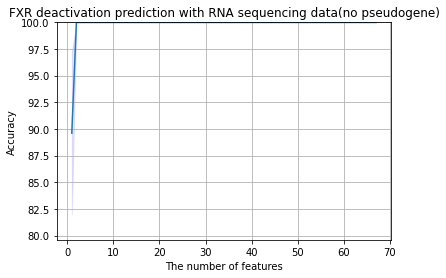

In [ ]:
draw_figure(rna_accuracy_list_no_pseudo,rna_no_pseudo_ci,rna_linear_features_important_no_pseudo,"FXR deactivation prediction with RNA sequencing data(no pseudogene)")

the least number of features to get the maximum accuracy 100.0%: 2
feature list: ['Acmsd', 'Vmn1r-ps32']


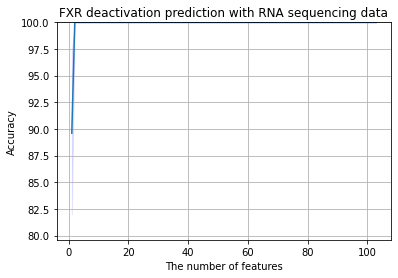

In [ ]:
draw_figure(rna_accuracy_list,rna_ci,rna_linear_features_important,"FXR deactivation prediction with RNA sequencing data")

the least number of features to get the maximum accuracy 100.0%: 10
feature list: ['melibiose', 'glucoheptulose', 'UDP-N-acetylglucosamine', 'uridine', 'squalene', 'isomaltose', 'ribose-5-phosphate', '2-hydroxybutanoic acid', 'arachidic acid', 'malic acid']


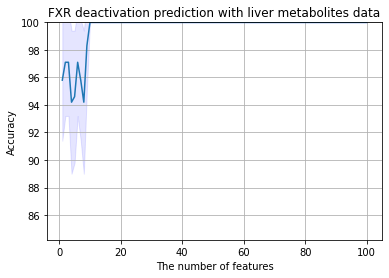

In [ ]:
draw_figure(liver_accuracy_list,liver_ci,liver_linear_features_important,"FXR deactivation prediction with liver metabolites data")

the least number of features to get the maximum accuracy 94.3%: 31
feature list: ['Valine', 'Lysine', 'Glycolate', 'sn_Glycero_3_phosphocholine', 'Threonine', 'Glutamine', 'Fumarate', 'Alanine', 'Urea', 'Tyrosine', 'Acetone', 'Glycerol', '3_Hydroxyisobutyrate', 'Proline', 'Leucine', 'O_Acetylcarnitine', '2_Hydroxyisobutyrate', 'Pyruvate', 'Formate', '2_Hydroxybutyrate', 'Carnitine', 'Ethanol', 'Methionine', 'Phenylalanine', 'Glutamate', 'Trimethylamine_N_oxide', 'Histidine', 'Isoleucine', 'Malate', '1.3_Dihydroxyacetone', 'Tryptophan']


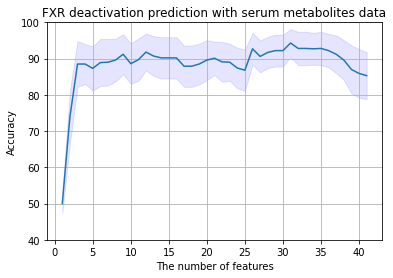

In [ ]:
draw_figure(serum_accuracy_list,serum_ci,serum_linear_features_important,"FXR deactivation prediction with serum metabolites data")

the least number of features to get the maximum accuracy 94.5%: 15
feature list: ['Succinate', 'Malate', 'Alanine', 'Glutamine', 'Acetone', 'Phenylalanine', 'Methionine', 'sn_Glycero_3_phosphocholine', 'Urea', 'Glycolate', 'Tyrosine', 'Valine', '2_Hydroxyisobutyrate', 'Glucose', '3_Hydroxyisobutyrate']


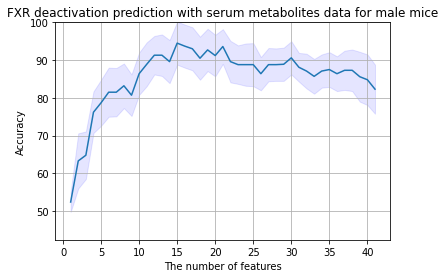

In [ ]:
draw_figure(serum_male_accuracy_list,serum_ci,serum_male_linear_features_important,"FXR deactivation prediction with serum metabolites data for male mice")

the least number of features to get the maximum accuracy 100.0%: 20
feature list: ['Creatinine', 'cis_Aconitate', 'N_Phenylacetylglycine', '5.6_Dihydrouracil', 'Glucose', 'Taurine', 'N_Methyl_2_pyridone_5_carboxamide', 'Pantothenate', 'N_Methyl_4_pyridone_3_carboxamide', 'Succinate', '1_Methylnicotinamide', '3_Indoxylsulfate', 'Allantoin', 'Guanidoacetate', '3_Methyl_2_oxovalerate', 'Uracil', 'Hippurate', 'Carnitine', 'Fucose', '2_Hydroxyvalerate']


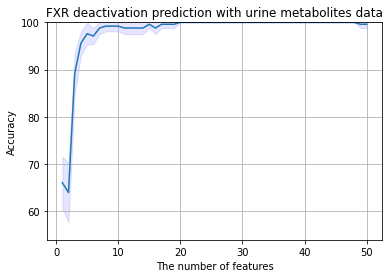

In [ ]:
draw_figure(urine_accuracy_list,urine_ci,urine_linear_features_important,"FXR deactivation prediction with urine metabolites data")

the least number of features to get the maximum accuracy 100.0%: 9
feature list: ['Creatinine', 'Taurine', 'Succinate', 'N_Phenylacetylglycine', 'Guanidoacetate', 'Pantothenate', 'trans_Aconitate', 'cis_Aconitate', 'N.N_Dimethylglycine']


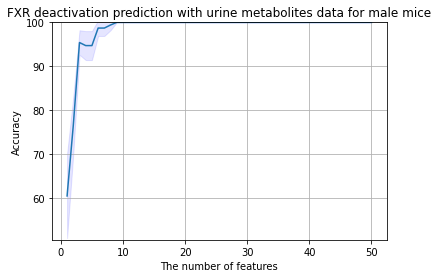

In [ ]:
draw_figure(urine_male_accuracy_list,urine_male_ci,urine_male_linear_features_important,"FXR deactivation prediction with urine metabolites data for male mice")

the least number of features to get the maximum accuracy 91.2%: 6
feature list: ['k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__;g__', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus', 'k__Bacteria;p__Firmicutes']


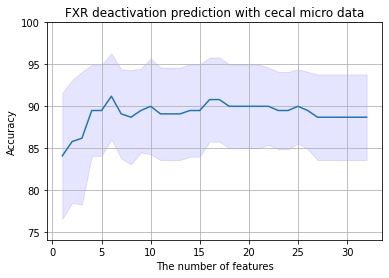

In [ ]:
draw_figure(cecal_accuracy_list,cecal_ci,cecal_linear_features_important,"FXR deactivation prediction with cecal micro data")

the least number of features to get the maximum accuracy 96.2%: 15
feature list: ['k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Oscillospira', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__;g__', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;Other', 'k__Bacteria;p__Tenericutes;c__Mollicutes;o__RF39;f__;g__', 'k__Bacteria;p__Tenericutes;c__Mollicutes;o__RF39;f__', 'k__Bacteria;p__Tenericutes;c__Mollicutes;o__RF39', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Parabacteroides', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_

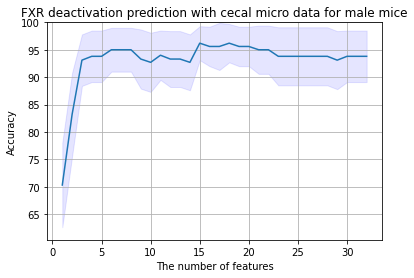

In [ ]:
draw_figure(cecal_male_accuracy_list,cecal_male_ci,cecal_male_linear_features_important,"FXR deactivation prediction with cecal micro data for male mice")

the least number of features to get the maximum accuracy 71.3%: 10
feature list: ['b-MCA', 'TCA', 'CA', 'DCA', 'UDCA', 'TLCA', 'TCDCA', 'HDCA', 'T-ab-MCA', 'LCA']


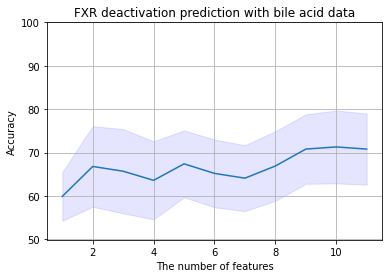

In [ ]:
draw_figure(bile_acid_accuracy_list,bile_acid_ci,bile_linear_features_important,"FXR deactivation prediction with bile acid data")